# Chicago Traffic Crash Data EDA
In this notebook, I'll be exploring Chicago traffic accident data from the [Chicago Data Portal](data.cityofchicago.org). Specifically, I'll be using these two datasets:
- [Traffic Crashes - Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)
- [Traffic Crashes - People](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d)

Here's a brief description of the first dataset, which I'll refer to from now on as the Crashes dataset:
> Crash data shows information about each traffic crash on city streets within the City of Chicago limits and under the jurisdiction of Chicago Police Department (CPD). Data are shown as is from the electronic crash reporting system (E-Crash) at CPD, excluding any personally identifiable information.

And here's a description of the second dataset, which I'll call the People dataset:
> This data contains information about people involved in a crash and if any injuries were sustained. This dataset should be used in combination with the traffic Crash and Vehicle dataset. Each record corresponds to an occupant in a vehicle listed in the Crash dataset. Some people involved in a crash may not have been an occupant in a motor vehicle, but may have been a pedestrian, bicyclist, or using another non-motor vehicle mode of transportation.

We can join the two datasets using the CRASH_RECORD_ID field:
> Person data can be linked with the Crash and Vehicle dataset using the “CRASH_RECORD_ID” field.

In [73]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

sns.set_style('dark')

In [74]:
data_root = Path('/home/hayden/proj/ml/traffic_accidents/data/chicago')
crashes_csv = Path(data_root, 'Traffic_Crashes_-_Crashes.csv')
people_csv = Path(data_root, 'Traffic_Crashes_-_People.csv')
                  
crashes_df = pd.read_csv(crashes_csv, dtype={'BEAT_OF_OCCURRENCE': 'float'}).set_index('CRASH_RECORD_ID')
# people_df = dd.read_csv(people_csv)

Let's examine the columns of the crashes dataset first.

In [75]:
crashes_df.columns

Index(['RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE',
       'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I',
       'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 'LONGITUDE

I don't like typing in upper case, so let's make these all lower case.

In [76]:
crashes_df.columns = map(str.lower, crashes_df.columns)
crashes_df.columns

Index(['rd_no', 'crash_date_est_i', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type', 'lane_cnt',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'intersection_related_i', 'not_right_of_way_i',
       'hit_and_run_i', 'damage', 'date_police_notified',
       'prim_contributory_cause', 'sec_contributory_cause', 'street_no',
       'street_direction', 'street_name', 'beat_of_occurrence',
       'photos_taken_i', 'statements_taken_i', 'dooring_i', 'work_zone_i',
       'work_zone_type', 'workers_present_i', 'num_units',
       'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown', 'crash_hour', 'crash_day_of_week', 'crash_month',
       'latitude', 'longitude

## Cleaning Null Values
Let's check out the null counts for each column.

In [77]:
crashes_df.isnull().sum()

rd_no                              1783
crash_date_est_i                 369190
crash_date                            0
posted_speed_limit                    0
traffic_control_device                0
device_condition                      0
weather_condition                     0
lighting_condition                    0
first_crash_type                      0
trafficway_type                       0
lane_cnt                         200139
alignment                             0
roadway_surface_cond                  0
road_defect                           0
report_type                        9409
crash_type                            0
intersection_related_i           310025
not_right_of_way_i               380167
hit_and_run_i                    287581
damage                                0
date_police_notified                  0
prim_contributory_cause               0
sec_contributory_cause                0
street_no                             0
street_direction                      2


Let's clean up some of these. Several of the injuries-related columns should be easy. For those columns reporting numbers of injuries, it seems reasonable to replace all nulls with zeros.

In [86]:
injury_cols = [
    'injuries_total',
    'injuries_fatal',
    'injuries_incapacitating',
    'injuries_non_incapacitating',
    'injuries_reported_not_evident',
    'injuries_unknown'
]
crashes_df[injury_cols] = crashes_df[injury_cols].fillna(0)
crashes_df[injury_cols].isnull().sum()

injuries_total                   0
injuries_fatal                   0
injuries_incapacitating          0
injuries_non_incapacitating      0
injuries_reported_not_evident    0
injuries_unknown                 0
dtype: int64

Let's see the number of crashes grouped by month.

In [78]:
crashes_df['crash_date'].head()

CRASH_RECORD_ID
00027e2894dd2f3fe4ff320a6d332d18e465b5c8ba2e7985d1aa4e5e8a4cda9a52a7627c1210281d8c7eefe757fe45e1585eaf80c0463cc9ed454bdd2ae20b2c    03/27/2019 04:20:00 PM
0002fb938eb0feaea33820fa55b71e4ea0b332125e15101c67a2e73971042abdd7daa58a4a14c43195d02902ca8cbdd1d3798055b4e129e194bfd26c77abb0d9    03/06/2018 03:00:00 PM
0003fc68d857da032b1beafa8f7893ce0b123ce6b2dee54c029bbd3b12902247b091033f7b6f62ed66ee97224e6dc5aed3eef2d007923a8d5000c63743005802    10/25/2016 02:10:00 PM
00060f93d2ae8d4e4c7fe75ac17055dd69a081d0b928a52655ccf9f719dab5e0ab62392ffe92aeed79bf3e1be2239745efad0e944f85eefb48f53c1cf41e19b2    01/21/2020 04:16:00 PM
0006882952e53c291df267014a03b57684383e9ad66d9e5723ff9cb22e76cbfbc7b6cd1ff0a3ceab28fc67638b47132e8d434cf510bc7bded7bfb98c95f569b5    10/04/2019 12:00:00 PM
Name: crash_date, dtype: object

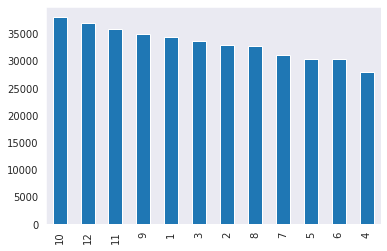

In [79]:
crashes_df['crash_month'].value_counts().plot(kind='bar');

Interestingly, the spring and summer months have fewer crashes than the fall and winter months. Just speculating, that could be because of poor weather conditions during the colder months. It could also be because of reckless/drunk driving around the holidays. Let's see the top 10 days of the year with the most crashes.

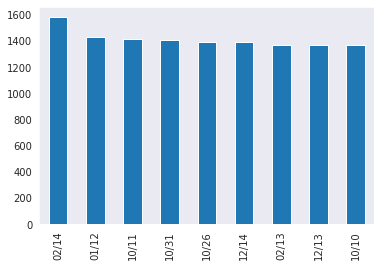

In [80]:
crashes_df['crash_day_of_year'] = crashes_df['crash_date'].str[0:5]
crashes_df['crash_day_of_year'].value_counts()[0:9].plot(kind='bar')

- 02/14 = Valentine's Day
- 01/12 = ???
- 10/11 = ???
- 10/31 = Halloween
- 10/26 = The weekend before Halloween?
- 12/14 = Christmas parties?
- 02/13 = Washington's Birthday can fall on 2/15, so 2/13 would be the Saturday before that.
- 12/13 = Christmas parties?
- 11/15 = Thanksgiving-related?

I'd like to plot the accident locations on a map of the city. For the time being, we'll filter out records where the latitude and longitude are null, or where they're both 0.

In [50]:
crashes_df = crashes_df.loc[crashes_df['latitude'].notnull()
                          & crashes_df['longitude'].notnull()
                          & (crashes_df['latitude'] != 0)
                          & (crashes_df['longitude'] != 0)]

We'll use [GeoPandas](https://geopandas.org/index.html) to help with plotting:
> GeoPandas is an open source project to make working with geospatial data in python easier. 

We'll load a [shapefile](https://en.wikipedia.org/wiki/Shapefile) of the city and then use our dataframe's longitude and latitude measurements to plot the sites of the crashes. You can get the shapefile I'm using [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw).

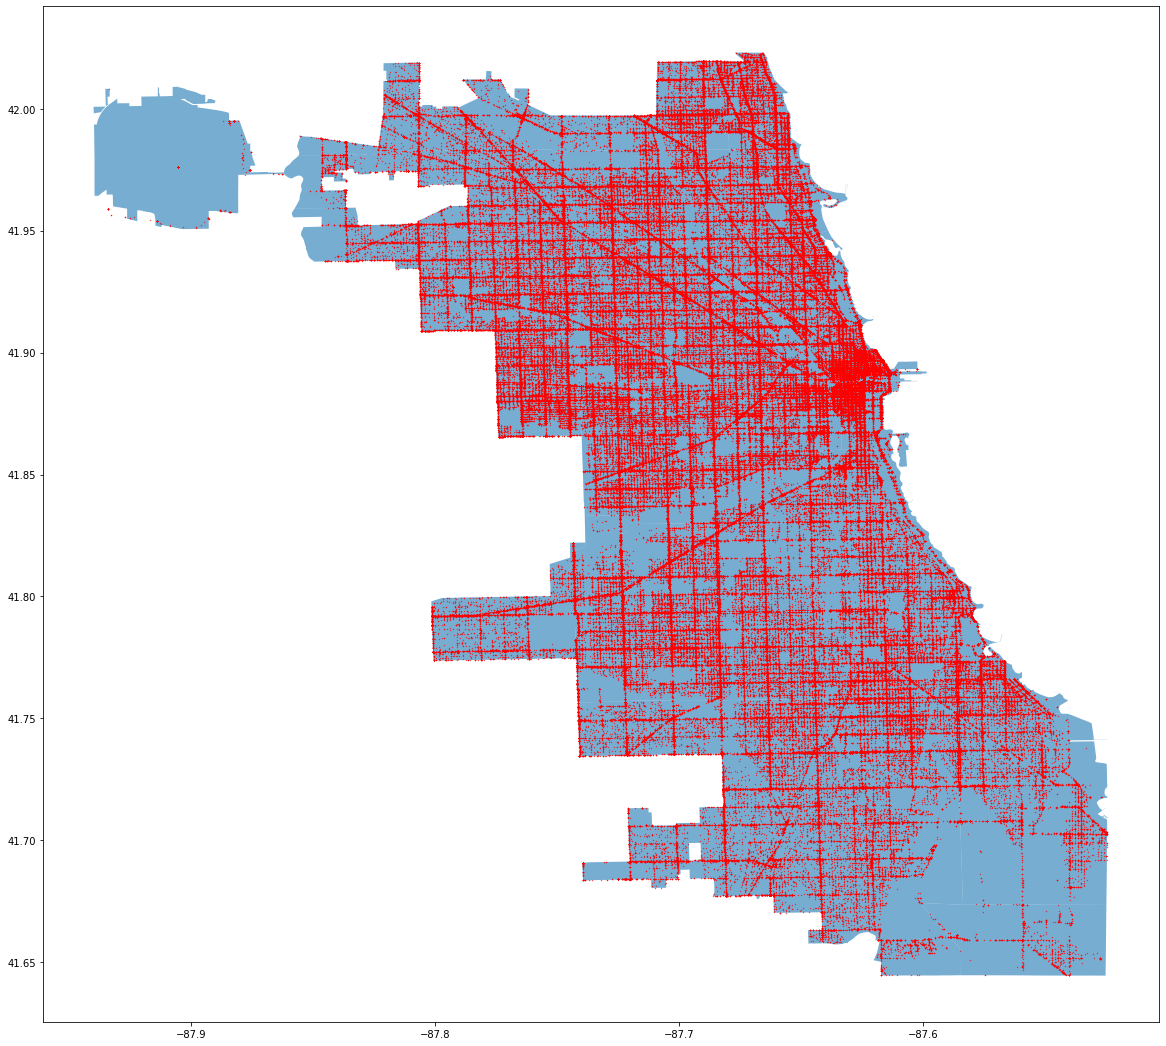

In [53]:
city_map = gpd.read_file(Path(data_root, 'shapefiles/geo_export_38005224-c9b0-494b-9e98-83ebe9fe4904.shp'))
gdf = gpd.GeoDataFrame(crashes_df, geometry=gpd.points_from_xy(crashes_df['longitude'], crashes_df['latitude']))

fig, ax = plt.subplots(figsize=(20, 20))
city_map.plot(ax=ax, alpha=0.6)
gdf.plot(ax=ax, color='red', markersize=0.1)

As of the writing of this post, the People dataset contains 867K records, and the Crash dataset contains 399K records. To keep memory usage reasonable, we'll be using Dask DataFrames. From the Dask [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html), Common Uses section:
> Dask DataFrame is used in situations where Pandas is commonly needed, usually when Pandas fails due to data size or computation speed.

If you've got a lot of RAM, you might be able to load these datasets in memory, but on my laptop, that's not feasible.

One thing I'd like to do is plot all the crash sites on a map of the city. However, we are missing latitude and longitude data for 2183 records. On the other hand, we're only missing the street name for a single record. We should be able to use the street names and numbers to fill in the missing latitude and longitude values. First, let's check if that one record missing a street name has latitude and longitude data.

In [12]:
crashes_df.loc[crashes_df['street_name'].isna(), ['street_no', 'latitude', 'longitude', 'location']]

,street_no,latitude,longitude,location
CRASH_RECORD_ID,,,,
bff6a680633aabb329cd3526586067cb604fbff7adf7c0c4ab0b512dc9862a5d1844b04d5f72ba750066d97f266d3915ccacdb0312d37b071b5721f1bed6e400,532,NaN,NaN,NaN


This record has no location information aside from the street number. Let's drop this record by only keeping records with non-null street names in the dataframe.

In [13]:
crashes_df = crashes_df.loc[crashes_df['street_name'].notnull()]

Let's verify that there are no records with a null street name, now.

In [14]:
crashes_df.loc[:, 'street_name'].isnull().sum()

0

Good. Now, we need to fill in the latitude and longitude values for the records that don't have them. Googling around, it seems like the geopy package will do what we want:
> geopy makes it easy for Python developers to locate the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources.

geopy is backed by a geolocation service of your choosing, such as Google Maps. We'll use [Nominatim](https://wiki.openstreetmap.org/wiki/Nominatim):
> Nominatim (from the Latin, 'by name') is a tool to search OSM data by name and address (geocoding) and to generate synthetic addresses of OSM points (reverse geocoding).

OSM is [OpenStreetMap](https://www.openstreetmap.org):
> OpenStreetMap is a map of the world, created by people like you and free to use under an open license.

Here's an example of how to use the package:

In [15]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='chicago_traffic_crashes')
location = geolocator.geocode('175 5th Avenue NYC')
print((location.latitude, location.longitude))

(40.741059199999995, -73.98964162240998)


So, we should be able to write a class that holds the geolocator object and has a function which takes the street number, street name, and city, and returns us the coordinates of that address. Note that I've added a 1 second sleep in the get_coordinates method. If we try to get_coordinates as fast as we can loop, [Nominatim will cut us off](https://operations.osmfoundation.org/policies/nominatim/).

In [16]:
import time

class AddrToCoordsConverter():
    def __init__(self, app_name):
        self.geolocator = Nominatim(user_agent=app_name)

    def get_coordinates(self, street_number, street_name, city):
        location = self.geolocator.geocode('{} {} {}'.format(street_number, street_name, city))
        time.sleep(1)
        if location:
            return (location.latitude, location.longitude)
        else:
            return None

Let's try it out with that example address.

In [17]:
addr_2_coords_conv = AddrToCoordsConverter('chicago_traffic_crashes')
addr_2_coords_conv.get_coordinates(175, '5th Avenue', 'NYC')

(40.741059199999995, -73.98964162240998)

We need to get all rows where the latitude and longitude are both null. We started with 2183 rows like this, then we dropped 1, so there should be 2182 left. Let's check.

In [18]:
len(crashes_df[crashes_df['latitude'].isnull() & crashes_df['longitude'].isnull()])

2182

Let's get an idea of what streets are problematic in terms of getting their latitude and longitude.

In [19]:
# crashes_df[crashes_df['latitude'].isnull() & crashes_df['longitude'].isnull()]['street_name'][0:10].value_counts().plot(kind='bar')

Let's iterate through the rows where the latitude and longitude are null and attempt to fill in those values using our converter class. This will take awhile, due to the half second sleep between requests to Nominatim. I'm gonna go have some coffee...

In [20]:
# null_location_idxs = crashes_df[crashes_df['latitude'].isnull() & crashes_df['longitude'].isnull()].index
# print('# nulls: {}.'.format(len(null_location_idxs)))

# for idx in null_location_idxs:
#     street_no, street_name = crashes_df.loc[idx, ['street_no', 'street_name']]
#     print('{} {}'.format(street_no, street_name))
#     lat_and_long = addr_2_coords_conv.get_coordinates(street_no, street_name, 'Chicago')
    
#     if lat_and_long:
#         crashes_df.loc[idx, ['latitude', 'longitude']] = lat_and_long
#     else:
#         print('No coordinates found.')

Good.